In [2]:
!pip install ucimlrepo

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo 
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# fetch dataset 
credit_approval = fetch_ucirepo(id=27) 
  
# data (as pandas dataframes) 
X = credit_approval.data.features 
y = credit_approval.data.targets 

#создаем датафрейм в удобном для нас формате pandas
df = pd.DataFrame(data=credit_approval.data.features, columns=credit_approval.variables.name)
#столбец A16 - таргет ("выдан займ или нет")
df['A16'] = y
#выведем пять первых строк нашего датафрейма, чтобы примерно понимать, как выглядят наши данные
df = df.drop(['A16'], axis=1) # удалим из датасета целевую переменную
df.head()


name,A15,A14,A13,A12,A11,A10,A9,A8,A7,A6,A5,A4,A3,A2,A1
0,0,202.0,g,f,1,t,t,1.25,v,w,g,u,0.000,30.83,b
1,560,43.0,g,f,6,t,t,3.04,h,q,g,u,4.460,58.67,a
2,824,280.0,g,f,0,f,t,1.50,h,q,g,u,0.500,24.50,a
3,3,100.0,g,t,5,t,t,3.75,v,w,g,u,1.540,27.83,b
4,0,120.0,s,f,0,f,t,1.71,v,w,g,u,5.625,20.17,b


In [4]:
# variable information 


# Заметим, что категориальные переменные по определению могут принимать только ограниченное и обычно фиксированное количество возможных значений. Это свойство понадобится нам 
# при заполнении пропусков
# Так же категориальные переменные в данном датафрейме принимают только буквенные значения
# для удобства разделим переменные на категориальные и непрерывные
# сразу же дропнем переменную A16, так как она таргетная (поэтому срез с 1-ой строки)
continuous = credit_approval.variables[1:][credit_approval.variables[1:]['type']=='Continuous']
categorical = credit_approval.variables[1:][credit_approval.variables[1:]['type']=='Categorical']

In [5]:
continuous

,name,role,type,demographic,description,units,missing_values
1,A15,Feature,Continuous,None,None,None,no
2,A14,Feature,Continuous,None,None,None,yes
5,A11,Feature,Continuous,None,None,None,no
8,A8,Feature,Continuous,None,None,None,no
13,A3,Feature,Continuous,None,None,None,no
14,A2,Feature,Continuous,None,None,None,yes


In [6]:
categorical


,name,role,type,demographic,description,units,missing_values
3,A13,Feature,Categorical,None,None,None,no
4,A12,Feature,Categorical,None,None,None,no
6,A10,Feature,Categorical,None,None,None,no
7,A9,Feature,Categorical,None,None,None,no
9,A7,Feature,Categorical,None,None,None,yes
10,A6,Feature,Categorical,None,None,None,yes
11,A5,Feature,Categorical,None,None,None,yes
12,A4,Feature,Categorical,None,None,None,yes
15,A1,Feature,Categorical,None,None,None,yes


In [7]:
# Заполним пропуски, а так же проиллюстрируем их заполнение:
# для начала в таблицу started_blanks запишем количество пропусков в каждом столбце
started_blanks = df.isna().sum()
# непосредственно заполним пропуска
for name in credit_approval.variables.name[1:]:
    if (df[name].isna().sum()!=0):
        if ((df[name].dtype == int) or (df[name].dtype == float)): # если в столбце не строки, а числа, то заполним средним значением (если переменные непрерывные)
            
            fill_value = df[name].mean()
            df[name].fillna(fill_value, inplace=True)
        else:
           
            # если переменная категориальная, то по свойству, описанному выше, кажется логичным заполнить пропуски самым популярным значением в столбце
            counted_values = df[name].value_counts()
            most_common =counted_values.idxmax()
            df[name].fillna(most_common, inplace=True)
# создадим еще одну таблицу с количеством пропусков, но уже в заполненном датафрейме
finished_blanks = df.isna().sum()

print("До заполнения")
print(started_blanks)
print("")
print("После заполнения")
print(finished_blanks)

До заполнения
name
A15     0
A14    13
A13     0
A12     0
A11     0
A10     0
A9      0
A8      0
A7      9
A6      9
A5      6
A4      6
A3      0
A2     12
A1     12
dtype: int64

После заполнения
name
A15    0
A14    0
A13    0
A12    0
A11    0
A10    0
A9     0
A8     0
A7     0
A6     0
A5     0
A4     0
A3     0
A2     0
A1     0
dtype: int64


Теперь изучим распределение переменных в столбцах, где каждый элемент - числовое значение. Иными словами, рассмотрим распределение непрерывных переменных:

Для начала выведем основную информацию о столбцах с непрерывными переменными

In [8]:
df.describe()
# count - The number of not-empty values.
# mean - The average (mean) value.
# std - The standard deviation.
# min - the minimum value.
# 25% - The 25% percentile*.
# 50% - The 50% percentile*.
# 75% - The 75% percentile*.
# max - the maximum value.

name,A15,A14,A11,A8,A3,A2
count,690.000000,690.000000,690.00000,690.000000,690.000000,690.000000
mean,1017.385507,184.014771,2.40000,2.223406,4.758725,31.568171
std,5210.102598,172.159274,4.86294,3.346513,4.978163,11.853273
min,0.000000,0.000000,0.00000,0.000000,0.000000,13.750000
25%,0.000000,80.000000,0.00000,0.165000,1.000000,22.670000
50%,5.000000,160.000000,0.00000,1.000000,2.750000,28.625000
75%,395.500000,272.000000,3.00000,2.625000,7.207500,37.707500
max,100000.000000,2000.000000,67.00000,28.500000,28.000000,80.250000


In [9]:

updatemenu = [dict()]
buttons = []
fig = go.Figure()
data =[]
for i in continuous.name:
    trace = px.histogram(df[i]).data[0]
    trace.visible = False
    data.append(trace) 
fig.add_traces(data) 

for i, col in enumerate(continuous.name):

    visibles = [False] * len(continuous.name)
    visibles[i] = True
    buttons.append(dict(method='restyle',
                        label=col,
                        args=["visible", visibles]
                        ))

updatemenu[0]['buttons'] = buttons
updatemenu[0]['direction'] = 'down'
updatemenu[0]['showactive'] = True

fig.update_layout(showlegend=True, updatemenus=updatemenu)
fig.update_layout(
     title={
        "text": "Распределение непрерывных переменных",
        "x": 0.5
    },
    xaxis_title="Диапазон",
    yaxis_title="Количество значений"
)
fig.show()

Теперь рассмотрим распределение категориальных переменных

In [10]:
updatemenu = [dict()]
buttons = []
fig2 = go.Figure()

data =[]
for i in categorical.name[1:]:
    trace = px.histogram(df[i]).data[0]
    trace.visible = False
    data.append(trace) 
fig2.add_traces(data) 

for i, col in enumerate(categorical.name):

    visibles = [False] * len(categorical.name)
    visibles[i] = True
    buttons.append(dict(method='restyle',
                        label=col,
                        args=["visible", visibles]
                        ))

updatemenu[0]['buttons'] = buttons
updatemenu[0]['direction'] = 'down'
updatemenu[0]['showactive'] = True

fig2.update_layout(showlegend=True, updatemenus=updatemenu)
fig2.update_layout(
     title={
        "text": "Распределение категориальных переменных",
        "x": 0.5
    },
    xaxis_title="Значение",
    yaxis_title="Количество значений"
)
fig2.show()



Также необходимо посмотреть на корреляцию непрерывных переменных

In [11]:
df.corr()

name,A15,A14,A11,A8,A3,A2
name,,,,,,
A15,1.000000,0.065609,0.063692,0.051345,0.123121,0.018539
A14,0.065609,1.000000,-0.119809,-0.076389,-0.222346,-0.077161
A11,0.063692,-0.119809,1.000000,0.322330,0.271207,0.185575
A8,0.051345,-0.076389,0.322330,1.000000,0.298902,0.392787
A3,0.123121,-0.222346,0.271207,0.298902,1.000000,0.201316
A2,0.018539,-0.077161,0.185575,0.392787,0.201316,1.000000


In [12]:
fig_cor = px.imshow(df.corr(), text_auto=True)
fig_cor.update_layout(
     title={
        "text": "Корреляция непрерывных переменных",
        "x": 0.5
    },

)
fig_cor.show()

Отсюда можем видеть, что A15 слабо коррелирует со всеми прочими признаками, а значит позже имеет смысл рассмотреть его подробнее.

Теперь поработаем с категориальными признаками. 

Очевидно, работать с некоторым дискретным набором строковых значений неудобно для анализа, поиска зависимостей и построения гипотез. В этом случае нас выручит метод преобразования категориальных столбцов в столбцы, где каждому из принимаемых признаком значений соответсвует единственная цифра.

Например, если у нас были признаки A1, A2, что содержали наборы значений из словаря {"a", "b", "c"}:

$$\begin{array}{cc}
A1 & A2 \\
a & b \\
c & a \\
b & c \\
a & b \\
\end{array}$$

то в измененном датафрейме при создании фиктивных переменных мы получим признаки $A1$, $A2$

$$\begin{array}{cc}
A1 & A2 \\
1 & 2 \\
3 & 1 \\
2 & 3 \\
1 & 2 \\
\end{array}$$

Возьмём признаки из списка "categorical":

In [13]:
categorical

,name,role,type,demographic,description,units,missing_values
3,A13,Feature,Categorical,None,None,None,no
4,A12,Feature,Categorical,None,None,None,no
6,A10,Feature,Categorical,None,None,None,no
7,A9,Feature,Categorical,None,None,None,no
9,A7,Feature,Categorical,None,None,None,yes
10,A6,Feature,Categorical,None,None,None,yes
11,A5,Feature,Categorical,None,None,None,yes
12,A4,Feature,Categorical,None,None,None,yes
15,A1,Feature,Categorical,None,None,None,yes


Разделим нашу выборку на тестовую и тренировачную

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)

In [15]:
!pip install category_encoders

In [16]:
import category_encoders as ce
encoder = ce.OrdinalEncoder(cols=['A13', 'A12', 'A10', 'A9', 'A7', 'A6', 'A5', 'A4', 'A1'])


X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)
y_test = y_test.replace({"+": 1, "-": 0})
y_train = y_train.replace({"+": 1, "-": 0})


Проведём небольшой EDA с фиктивными переменными. Для начала, исследуем корреляцию:

In [17]:

fig_cor = px.imshow(X_train.corr(), text_auto=True)
fig_cor.update_layout(
     title={
        "text": "Корреляция вместе c фиктивными переменных, представляющих категориальные",
        "x": 0.5
    },

)
fig_cor.show()


In [18]:
X_train.describe()

name,A15,A14,A13,A12,A11,A10,A9,A8,A7,A6,A5,A4,A3,A2,A1
count,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000,552.000000
mean,920.070652,180.527522,1.103261,1.452899,2.400362,1.429348,1.512681,2.048134,2.757246,6.793478,1.755435,1.755435,4.604520,31.468865,1.298913
std,4787.304994,163.664540,0.349005,0.498228,4.853296,0.495432,0.500293,2.923399,1.441837,3.727189,0.434417,0.434417,4.807331,11.754812,0.458197
min,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,13.750000,1.000000
25%,0.000000,80.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.165000,2.000000,4.000000,2.000000,2.000000,1.030000,22.730000,1.000000
50%,5.000000,160.000000,1.000000,1.000000,0.000000,1.000000,2.000000,1.000000,2.000000,7.000000,2.000000,2.000000,2.750000,28.580000,1.000000
75%,400.000000,269.000000,1.000000,2.000000,3.000000,2.000000,2.000000,2.551250,4.000000,10.000000,2.000000,2.000000,7.000000,37.500000,2.000000
max,100000.000000,2000.000000,3.000000,2.000000,67.000000,2.000000,2.000000,20.000000,9.000000,14.000000,3.000000,3.000000,26.335000,80.250000,2.000000


Начнём играться с моделями машинного обучения. Рассмотрим самую простенькую модель линейной регрессии:

In [19]:
# создание модели линейной регрессии
model = LinearRegression()

# обучение модели
model.fit(X_train, y_train)

# получение прогнозов
y_pred = model.predict(X_test)

# оценка качества модели
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Вывод результатов
print(f"Среднеквадратичная ошибка (MSE): {mse}")
print(f"Коэффициент детерминации (R^2): {r2}")

print("\n")

# Получение коэффициентов регрессии
coefficients = pd.DataFrame({'Признак': X_train.columns.ravel(), 'Коэффициент': model.coef_.ravel()})
print(coefficients)

Среднеквадратичная ошибка (MSE): 0.13379585750343687
Коэффициент детерминации (R^2): 0.46470413649255227


   Признак  Коэффициент
0      A15     0.000012
1      A14    -0.000063
2      A13     0.077671
3      A12    -0.025052
4      A11     0.007073
5      A10     0.137167
6       A9     0.619654
7       A8     0.009137
8       A7    -0.005919
9       A6     0.008355
10      A5     0.032494
11      A4     0.032494
12      A3    -0.003093
13      A2     0.001164
14      A1     0.018429


/var/folders/q2/14m9wqwd7blcr7txyywgdkkm0000gn/T/ipykernel_51582/378686754.py:21: FutureWarning:

Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.



Проиллюстрируем работу модели линейно регрессии:

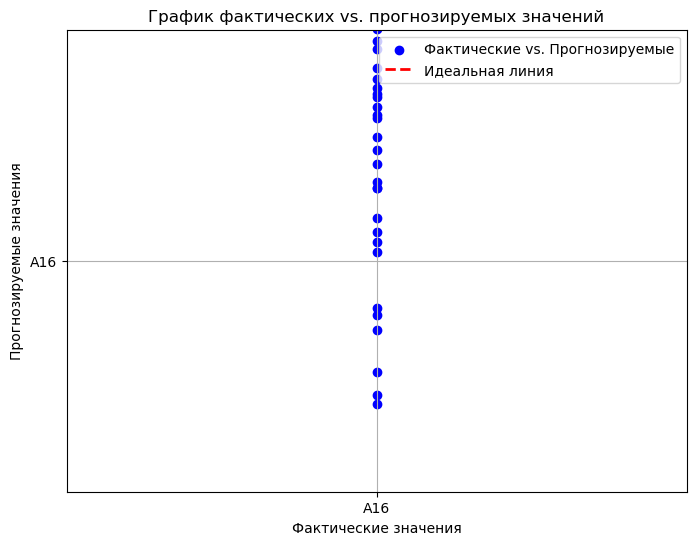

In [20]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Фактические vs. Прогнозируемые')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2, label='Идеальная линия')
plt.xlabel('Фактические значения')
plt.ylabel('Прогнозируемые значения')
plt.title('График фактических vs. прогнозируемых значений')
plt.legend()
plt.grid(True)

plt.show()

Теперь возьмём модель логистической регрессии:

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# создание модели логистической регрессии
model = LogisticRegression()

# обучение модели
model.fit(X_train, y_train)

# получение прогнозов
y_pred = model.predict(X_test)

# оценка качества модели
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

# печать точности, матрица ошибок и отчёта о классификации
print(f"Точность модели: {accuracy:.2f}")
print("Матрица ошибок (Confusion Matrix):")
print(confusion)
print("Отчет о классификации:")
print(classification_report_str)

/Users/amirzoyeva/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Точность модели: 0.76
Матрица ошибок (Confusion Matrix):
[[60  8]
 [25 45]]
Отчет о классификации:
              precision    recall  f1-score   support

           0       0.71      0.88      0.78        68
           1       0.85      0.64      0.73        70

    accuracy                           0.76       138
   macro avg       0.78      0.76      0.76       138
weighted avg       0.78      0.76      0.76       138



/Users/amirzoyeva/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



## Модель классификации ##

In [22]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

print('Model accuracy: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))


Model accuracy: 0.8478


/var/folders/q2/14m9wqwd7blcr7txyywgdkkm0000gn/T/ipykernel_51582/4027964348.py:4: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



In [26]:
features_importance = pd.Series(rfc.feature_importances_, index=X_train.columns).sort_values(ascending=False)
features_importance

name
A9     0.312358
A8     0.100574
A15    0.083582
A11    0.083448
A3     0.075221
A2     0.073622
A14    0.068563
A10    0.062168
A6     0.048351
A7     0.027144
A13    0.014781
A5     0.013378
A12    0.013068
A4     0.012020
A1     0.011722
dtype: float64

In [27]:
fig = px.bar(x=features_importance.index, y=features_importance)
fig.update_layout(
     title={
        "text": "Важность признаков",
        "x": 0.5
    },
    xaxis_title="Признак",
    yaxis_title="Показатель важности"
)
fig.update_xaxes(categoryorder='total ascending')  
fig.show()


In [28]:
cm = confusion_matrix(y_test, y_pred)

fig_mis = px.imshow(cm, text_auto=True)
fig_mis.update_layout(
     title={
        "text": "Матрица ошибок для модели классификации RFC",
        "x": 0.5
    },

)
fig_mis.show()